# Unsupervised machine learning

Previously, we have taken MR images and attempt assign to them values of normal/diseased, at a whole image level (classification) or a pixel level (segmentation). But what if we don't have labels?

We are going to spent this tutorial exploring how to find patterns in data using unsupervised machine learning. We'll introduce three new tools that require no labels (though we'll keep track of them to evaluate our performance):

- Autoencoders: deep neural network designed minimize the "reconstruction error" between the input and output (which are the same)
- K-means clustering: a way of automatically find groups of unlabelled data points in space based on distances between them
- K-nearest neighbours: assigning a new data point a label based on its proximity to other labelled data points

In [1]:
%load_ext autoreload
train_path = 'C:/Users/jxb29/Dropbox (Partners HealthCare)/Teaching/BRATS_10_Updated/*/*.nii.gz'
sequences = ['t1', 't2', 't1ce', 'flair']

In [2]:
from skimage.measure import label, regionprops

def normalize_images(channel_copy):
        
    label_image = label(channel_copy == 0)

    largest_label, largest_area = None, 0
    for region in regionprops(label_image):
        if region.area > largest_area:
            largest_area = region.area
            largest_label = region.label

    mask = label_image == largest_label     
    masked_channel = np.ma.masked_where(mask, channel_copy)

    masked_channel = masked_channel - np.mean(masked_channel)
    masked_channel = masked_channel / np.std(masked_channel)
    masked_channel = np.ma.getdata(masked_channel)
    return masked_channel

In [3]:
from glob import glob
import nibabel as nib
from os.path import basename
import numpy as np 

all_images = glob(train_path)

slices = []
labels = []
no_slices = 40

for nifti_file in all_images:
    
    seq = basename(nifti_file).split('.')[0].split('_')[-1]
    
    if seq not in sequences:
        continue
    
    # Load Nifti file, normalize it
    vol = nib.load(nifti_file).get_data()
    vol = normalize_images(vol)
    
    # Take a middle-ish section of the volume
    halfway_point = vol.shape[2] // 2
    sample = [vol[:,:,i] for i in range(halfway_point-(no_slices//2), halfway_point+(no_slices//2))]
    slices.extend(sample)
    
    # Keep track of the labels (sequence ID: 0 == t1, 1 == t2)
    index = sequences.index(seq)
    index_list = [index] * no_slices
    labels.extend(index_list)

C:\Users\jxb29\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [4]:
# (samples: 40 * N, rows: 240, columns: 240, channels: 1)
X = np.expand_dims(np.asarray(slices), axis=-1)
y = np.asarray(labels)
print(X.shape, y.shape)

(1760, 240, 240, 1) (1760,)


In [5]:
import h5py
from keras.utils.io_utils import HDF5Matrix
from keras.preprocessing.image import ImageDataGenerator


def save_hdf5_file(train_data, output_filename):
    
    with h5py.File(output_filename, 'w') as file_handle:
        file_handle.create_dataset('train', data=train_data, dtype=train_data.dtype)

class ReconGenerator:
  
    def __init__(self, training_data, save_file, batch_size=20, augmentation=None):
    
        self.training_data = training_data
        self.save_file = save_file
        self.batch_size = batch_size
        self.augmentation = augmentation
        self.seed = 1989

        self.X_train = None
        save_hdf5_file(training_data, self.save_file)
        self.X_train = HDF5Matrix(self.save_file, 'train')

    def generator(self):

        aug_dict = dict()
        if self.augmentation is not None:
            aug_dict = self.augmentation

        X_datagen = ImageDataGenerator(**aug_dict)
        X_generator = X_datagen.flow(self.X_train, seed=self.seed, batch_size=self.batch_size, shuffle=True)

        return zip(X_generator, X_generator)

Using TensorFlow backend.


In [6]:
batch_size = 20
recon_gen = ReconGenerator(X, 'ae_data.h5').generator()

In [8]:
%autoreload 2
import models
ae = models.autoencoder(image_shape=X.shape[1:])
ae.compile(loss='mse', optimizer='sgd', metrics=['mae'])
ae.fit_generator(recon_gen, epochs=5, steps_per_epoch=X.shape[0] // batch_size)
ae.save_weights('ae_weights.h5')

Epoch 1/5
88/88 [==============================] - 512s 6s/step - loss: 0.4227 - mean_absolute_error: 0.3541
Epoch 2/5
88/88 [==============================] - 496s 6s/step - loss: 0.2703 - mean_absolute_error: 0.2640
Epoch 3/5
88/88 [==============================] - 464s 5s/step - loss: 0.2623 - mean_absolute_error: 0.2503
Epoch 4/5
88/88 [==============================] - 464s 5s/step - loss: 0.2602 - mean_absolute_error: 0.2439
Epoch 5/5
88/88 [==============================] - 463s 5s/step - loss: 0.2589 - mean_absolute_error: 0.2399


In [9]:
import models
encoder = models.autoencoder(image_shape=X.shape[1:], encoder_only=True)
encoder.load_weights('ae_weights.h5', by_name=True)

In [10]:
features = encoder.predict(X)

In [11]:
print(features.shape)

(1760, 57600)


In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1)
T = tsne.fit_transform(features)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1760 samples in 3.764s...
[t-SNE] Computed neighbors for 1760 samples in 322.614s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1760
[t-SNE] Computed conditional probabilities for sample 1760 / 1760
[t-SNE] Mean sigma: 4.052459
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.490974
[t-SNE] Error after 1000 iterations: 0.404448


In [13]:
print(T.shape)

(1760, 2)


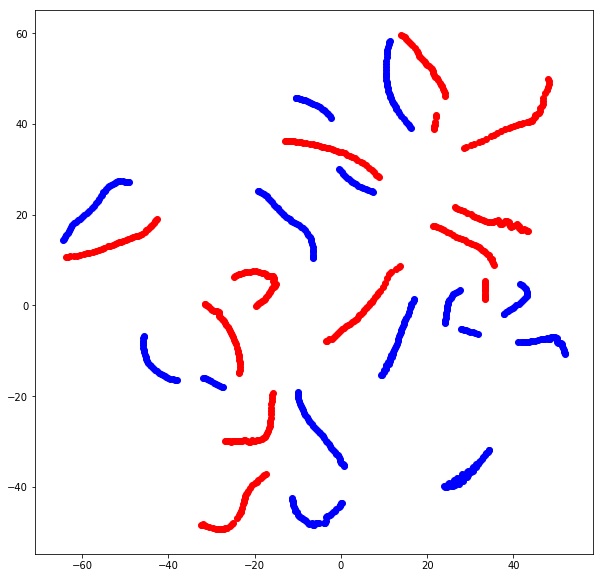

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

for c, i in {'r': 0, 'b': 1}.items():
    
    idx = y == i
    plt.scatter(T[idx, 0], T[idx, 1], c=c)
plt.show()